In [1]:
'''
The simulations with synthetic data to test the behavior of MOS in different data structure.
'''

import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

# Print df_degfieldd without truncation
pd.set_option('display.max_rows', None)


In [2]:
def compute_mci_hajime(A, At=None, mci_init=None, iter=250, output_other_side=False):
    M, N = A.shape
    if mci_init is None:
        assert np.all(np.isin(A,[0,1])), "A must be binary matrix if mci_init is not provided."
        mci_init = A.sum(axis=1)
    mci = mci_init.copy().values.reshape([-1,1])
    if At is None:
        At = A.T
    Aw = A/np.sum(A,axis=1).values.reshape(M,1)
    Atw = At/np.sum(At,axis=1).values.reshape(N,1)

    result_mci = pd.DataFrame(index=A.index)
    result_mci[f'iter_{0}'] = mci
    result_oci = pd.DataFrame(index=A.columns)
    for i in range(iter):
        oci = np.dot(Atw,mci)
        mci = np.dot(Aw,oci)
        # oci = (oci - oci.mean())/oci.std()
        # mci = (mci - mci.mean())/mci.std()
        oci = (oci - oci.min())/(oci.max()-oci.min()) + 1e-5
        mci = (mci - mci.min())/(mci.max()-mci.min()) + 1e-5
        result_mci[f'iter_{i+1}'] = mci
        result_oci[f'iter_{i+1}'] = oci
    if output_other_side:
        return result_mci, result_oci
    else:
        return result_mci


def binarize_by_rca(df_adj):
    # Construct the binary matrix.
    ## Methods: Threshold with certain number, or revealed comparative advantage.
    binarize_method='rca'
    major_share = (df_adj.T/df_adj.sum(axis=1) ).T #Share of an occupation within a major
    if binarize_method == 'rca':
        binarize_threshold = 1.
        occupation_share = df_adj.sum(axis=0)/df_adj.sum().sum()
        rca = major_share/occupation_share
        major_occupation_matrix = (rca>binarize_threshold).astype(int)

    return major_occupation_matrix




In [3]:
df_degfield = pd.read_csv('../data/processed_data/acs/degfield_mapping.csv', index_col=0)
df_degfieldd = pd.read_csv('../data/processed_data/acs/degfieldd_mapping.csv', index_col=0)
# 24 is engineering. 37	mathematics and statistics

major_ref_top_degfield = 21 #computer and information sciences
major_ref_bottom_degfield = 60 #fine arts
major_ref_top_degfieldd = 2102 #computer science
major_ref_bottom_degfieldd = 6000 #drama and theater arts

iterations = 25
binarize_method = 'rca'

soc_level = 2
major_var = 'degfieldd'
major_name = df_degfield if major_var == 'degfield' else df_degfieldd
major_name.index.name = 'major'
if binarize_method == 'rca':
    binarize_threshold = 1.

# Read data
adj_matrix = pd.read_csv(f'../data/processed_data/acs/adj_{major_var}_soc{soc_level}.csv',index_col=0)




In [4]:
df_degfieldd

,degfieldd_s
major,
1100,general agriculture
1101,agriculture production and management
1102,agricultural economics
1103,animal sciences
1104,food science
1105,plant science and agronomy
1106,soil science
1199,miscellaneous agriculture
1301,environmental science


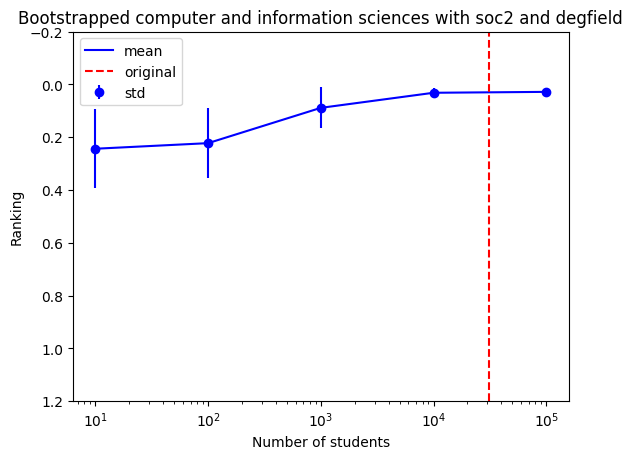

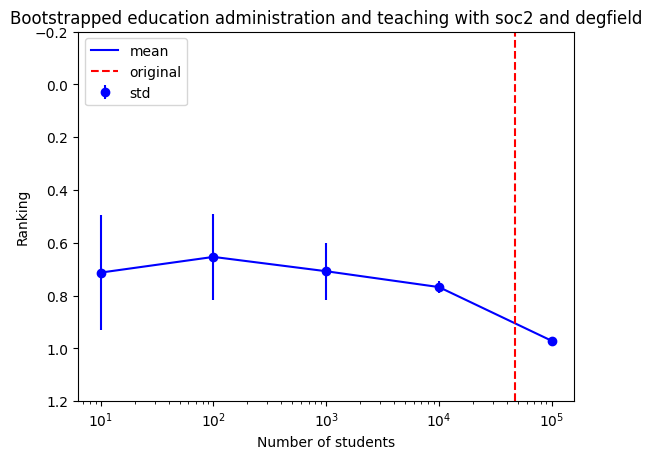

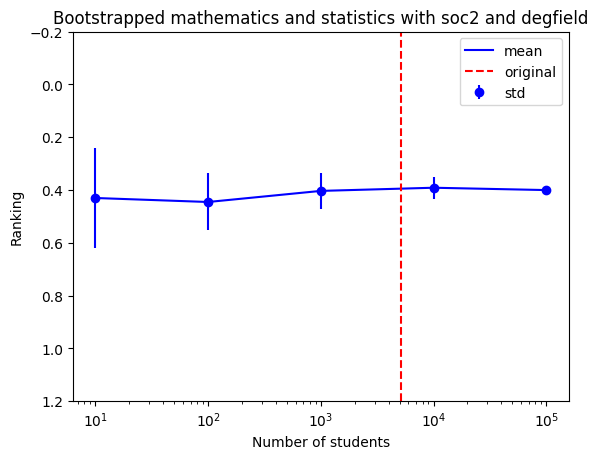

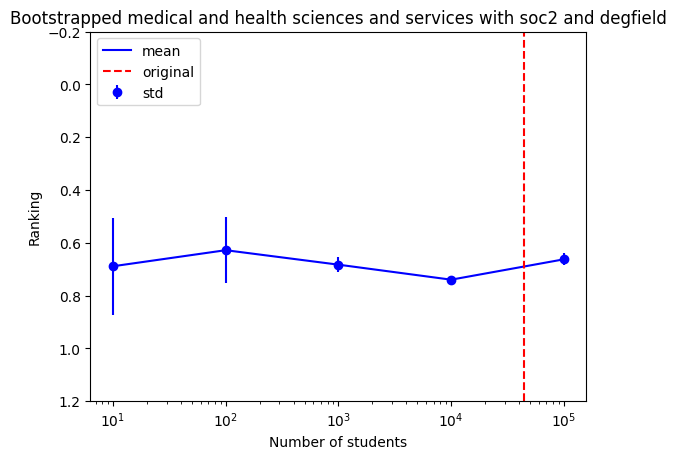

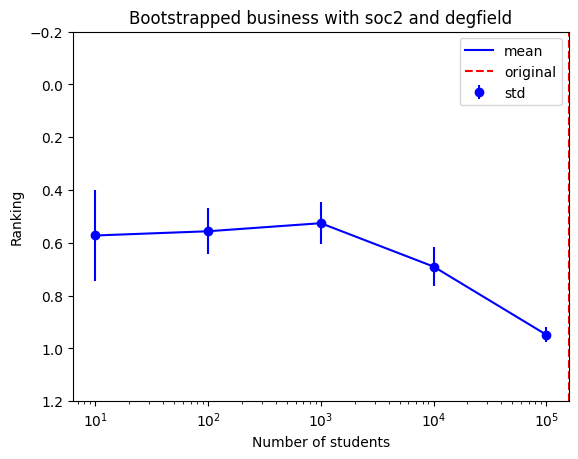

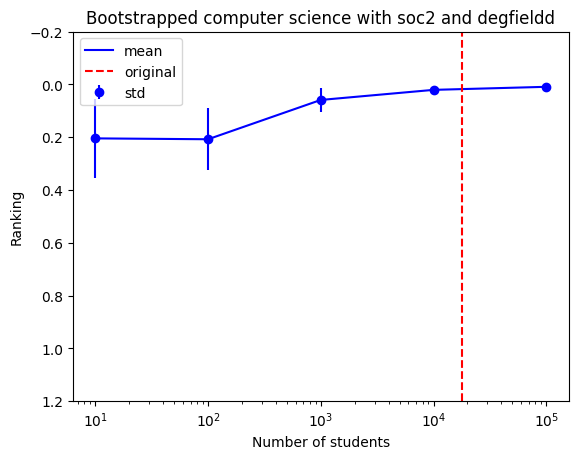

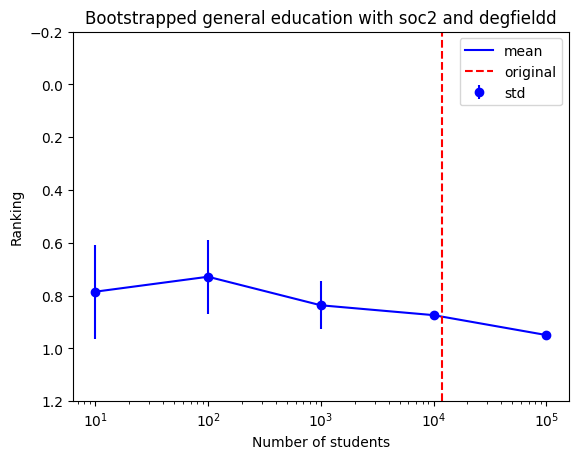

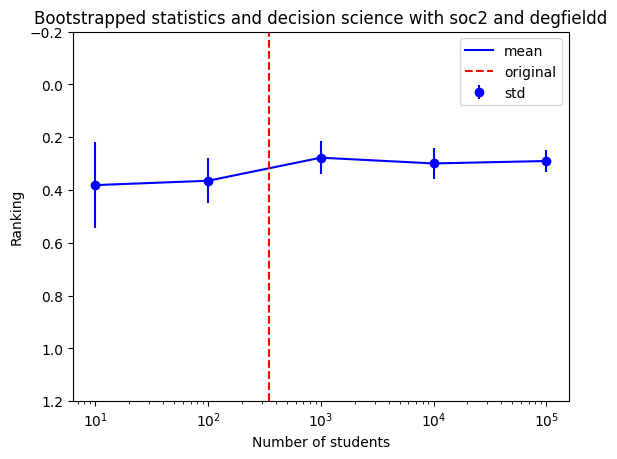

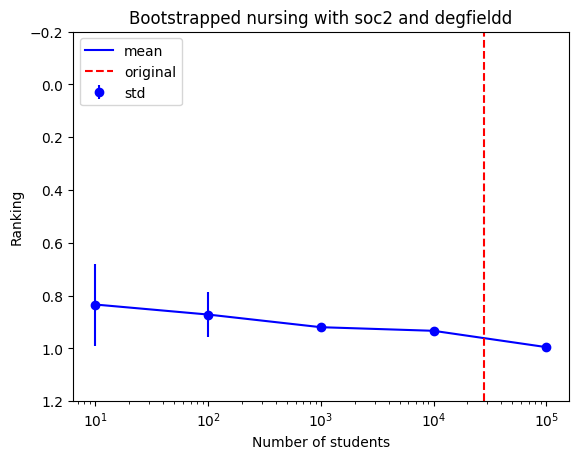

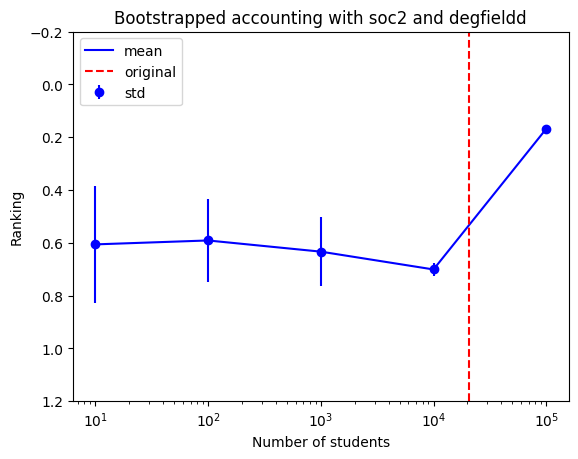

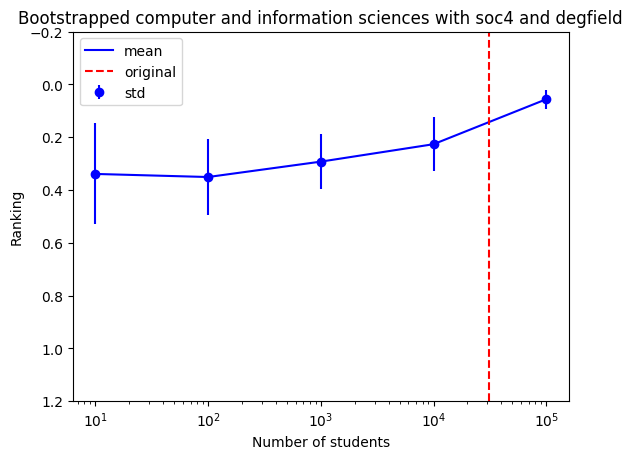

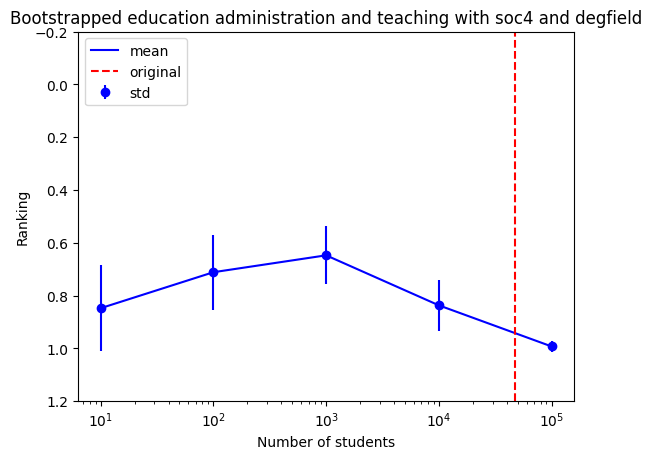

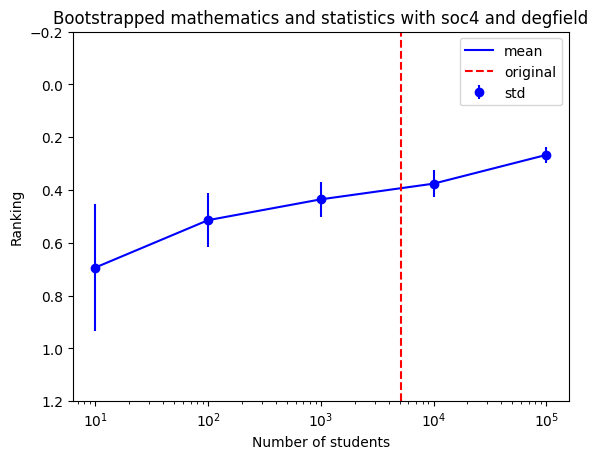

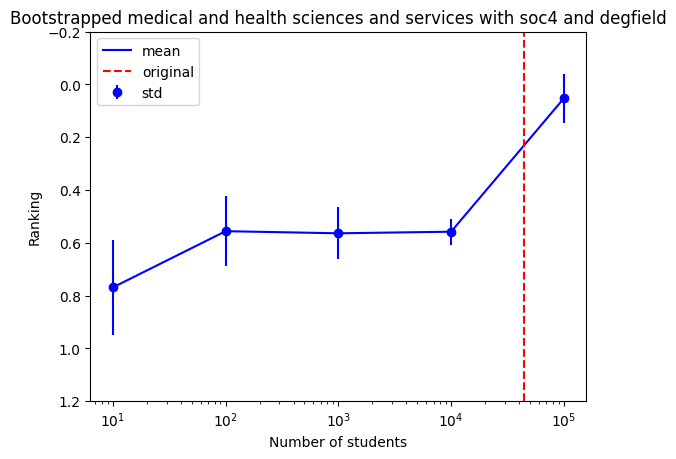

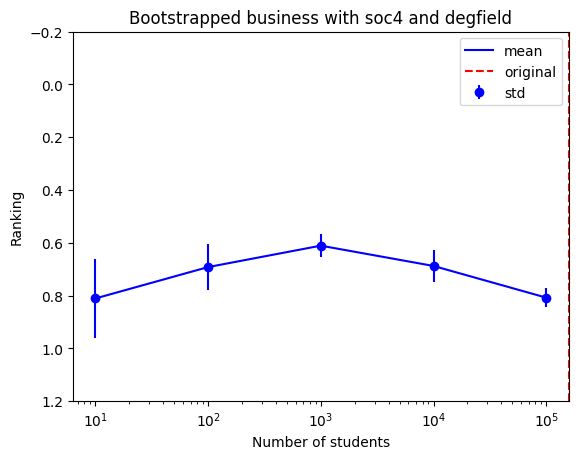

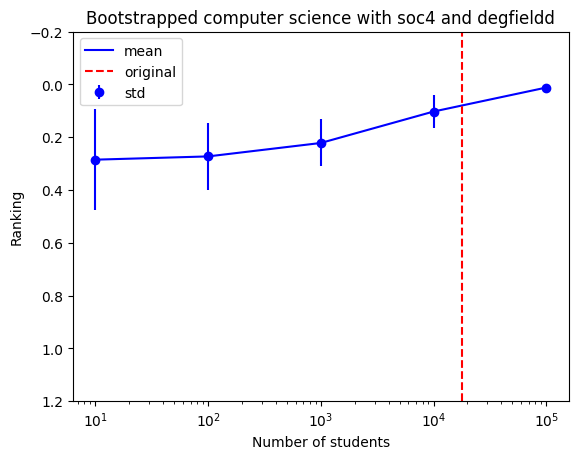

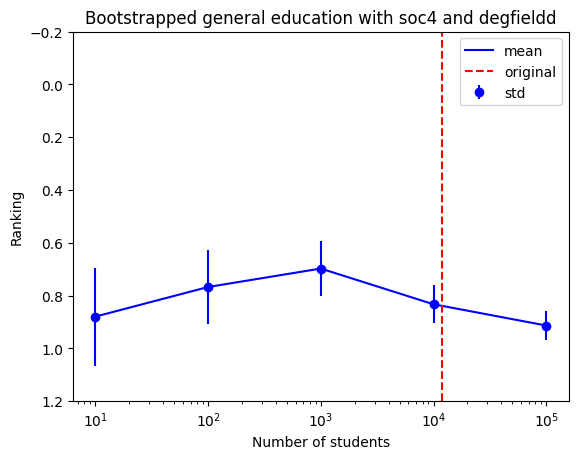

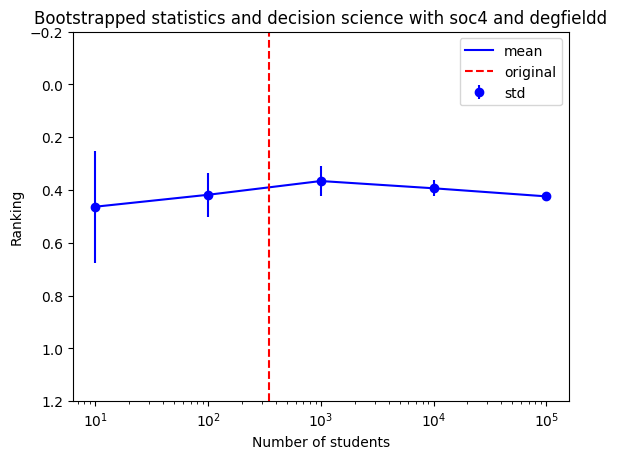

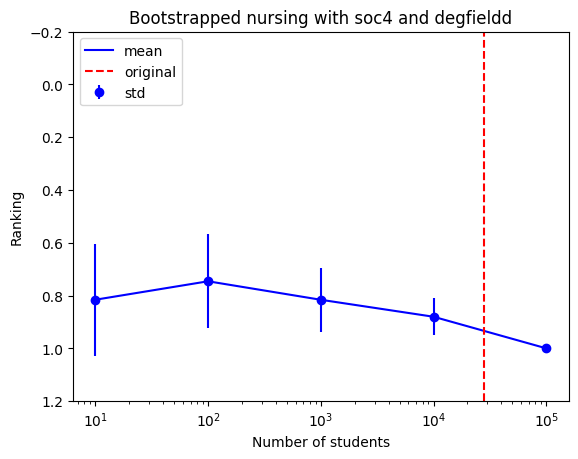

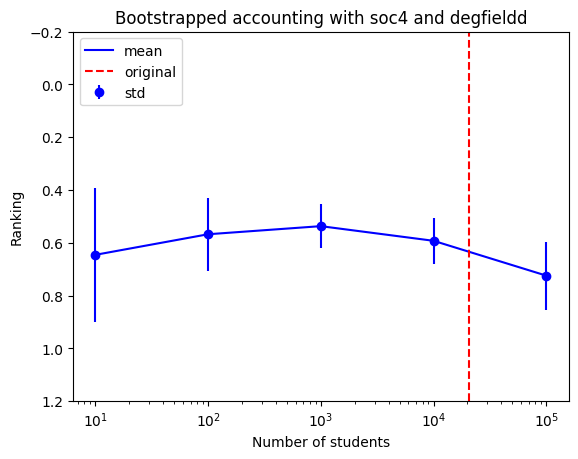

In [5]:

for soc_level in [2,4]:
    for major_var in ['degfield','degfieldd']:
        for target_major in [2102, 2300, 3702,6107,6201]:#
            major_i = target_major if major_var == 'degfieldd' else int(str(target_major)[:2])            

            major_name = df_degfield if major_var == 'degfield' else df_degfieldd
            major_name.index.name = 'major'
            adj_matrix = pd.read_csv(f'../data/processed_data/acs/adj_{major_var}_soc{soc_level}.csv',index_col=0)


            major_i_occ_ratio = adj_matrix.loc[major_i]/adj_matrix.loc[major_i].sum()
            major_i_original_num = adj_matrix.loc[major_i].sum()
            binary_matrix = binarize_by_rca(adj_matrix)
            mci_original = compute_mci_hajime(binary_matrix, iter=iterations)
            ranking_original = mci_original.iloc[:,-1].rank(ascending=True)


            major_i_ranking_iter = pd.DataFrame()
            major_i_sum_rca = pd.DataFrame()
            major_i_mci =  pd.DataFrame()

            for n in [10,100,1000,10000,100000]:
                major_i_rankings_ = []
                major_i_rca_ = []
                major_i_mci_ = []
                for i in range(100):
                    ranking_df = pd.DataFrame(index=adj_matrix.index)

                    simulated_outcome = np.random.choice(adj_matrix.columns,p=major_i_occ_ratio, size=n)
                    count = np.unique( simulated_outcome,return_counts=True)
                    count = pd.Series(count[1],index=count[0])

                    # Replace adj_matrix_simulation.loc[major_i] with count
                    adj_matrix_simulation = adj_matrix.copy()
                    adj_matrix_simulation.loc[major_i] = count

                    binary_matrix = binarize_by_rca(adj_matrix_simulation)
                    mci_b_H = compute_mci_hajime(binary_matrix, iter=iterations)
                    ranking = mci_b_H.iloc[:,-1].rank(ascending=True)

                    # Adjust the direction
                    major_ref_top = major_ref_top_degfieldd if major_var == 'degfieldd' else major_ref_top_degfield
                    major_ref_bottom = major_ref_bottom_degfieldd if major_var == 'degfieldd' else major_ref_bottom_degfield
                    if ranking[major_ref_top]>ranking[major_ref_bottom]:
                        mci_b_H = -mci_b_H
                        ranking = mci_b_H.iloc[:,-1].rank(ascending=True)


                    major_i_rankings_.append(ranking[major_i])
                    major_i_rca_.append(binary_matrix.loc[major_i].sum())
                    major_i_mci_.append(mci_b_H.iloc[:,-1].loc[major_i])
                major_i_ranking_iter[n] = pd.Series(major_i_rankings_).describe()
                major_i_sum_rca[n] = pd.Series(major_i_rca_).describe()
                major_i_mci[n] = pd.Series(major_i_mci_).describe()



            n_effective_majors = adj_matrix.shape[0]
            # Plot engineer_ranking_iter across n
            fig, ax = plt.subplots()
            ax.plot(major_i_ranking_iter.loc['mean']/n_effective_majors, label='mean',color='blue')
            ## Show std as error bar
            ax.errorbar(major_i_ranking_iter.columns, major_i_ranking_iter.loc['mean']/n_effective_majors, yerr=major_i_ranking_iter.loc['std']/n_effective_majors, fmt='o', label='std',color='blue')
            ax.set_xscale('log')
            #dashed vertical line for the actual number 
            ax.axvline(major_i_original_num, color='red', linestyle='--', label='original')
            ax.set_title(f'Bootstrapped {major_name.loc[major_i].values[0]} with soc{soc_level} and {major_var}')
            
            ax.set_xlabel('Number of students')
            ax.set_ylabel('Ranking')

            # Flip y-axis
            ax.invert_yaxis()
            # Fix y-axis in 0-1
            ax.set_ylim(1.2,-.2)


            # Save fig
            plt.legend()
            plt.savefig(f'../results_JHR_revision2/bootstrapped_{major_name.loc[major_i].values[0].replace(" ","_")}_soc{soc_level}_{major_var}_ranking.pdf')

            plt.show()


In [6]:
major_i_ranking_iter

,10,100,1000,10000,100000
count,100.000000,100.000000,100.000000,100.000000,100.000000
mean,102.700000,90.300000,85.420000,94.240000,115.210000
std,40.373884,21.921117,13.143482,13.811224,20.479255
min,1.000000,45.000000,55.000000,61.000000,67.000000
25%,75.750000,76.000000,76.000000,84.000000,98.750000
50%,112.000000,88.000000,87.000000,92.500000,116.000000
75%,133.000000,101.000000,89.000000,100.250000,130.000000
max,159.000000,144.000000,123.000000,131.000000,148.000000


In [7]:
soc_level = 2
major_var = 'degfieldd'
major_name = df_degfield if major_var == 'degfield' else df_degfieldd
major_name.index.name = 'major'
if binarize_method == 'rca':
    binarize_threshold = 1.

# Read data
adj_matrix = pd.read_csv(f'../data/processed_data/acs/adj_{major_var}_soc{soc_level}.csv',index_col=0)

binary_matrix = binarize_by_rca(adj_matrix)
mci_original = compute_mci_hajime(binary_matrix, iter=iterations)
ranking_original = mci_original.iloc[:,-1].rank(ascending=True)


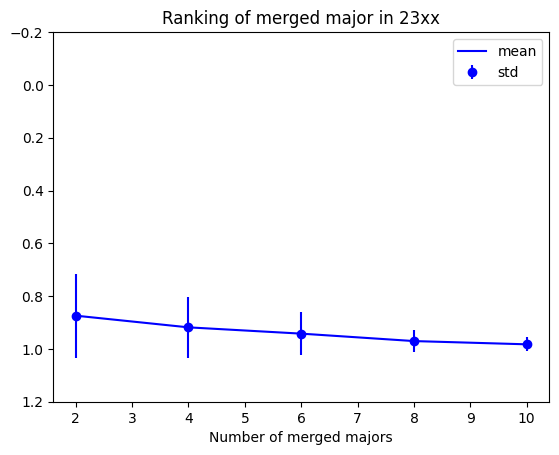

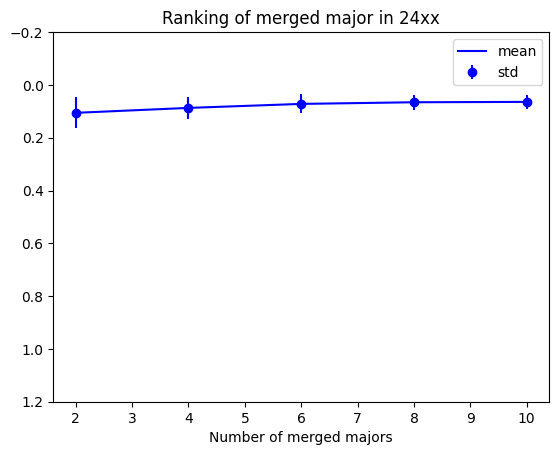

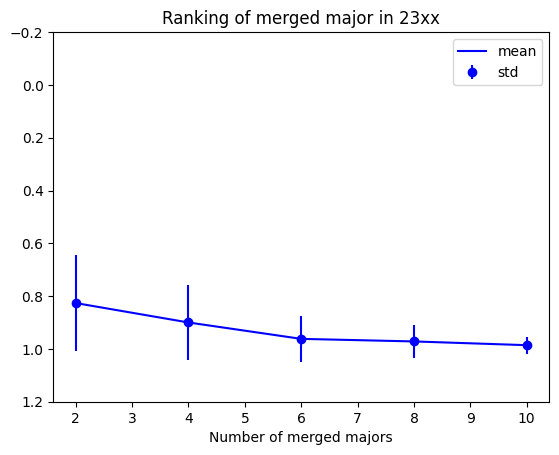

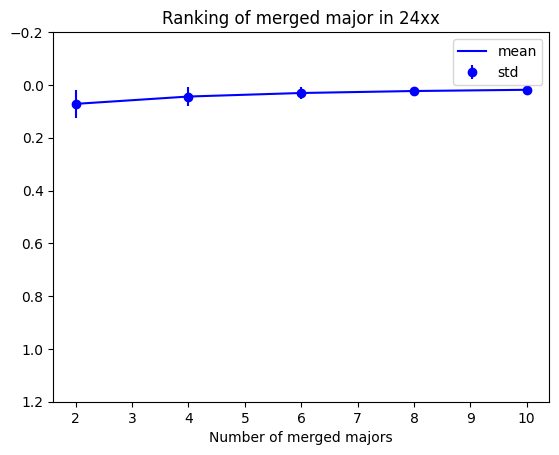

In [8]:
for soc_level in [2,4]:
    major_var = 'degfieldd'
    major_name = df_degfield if major_var == 'degfield' else df_degfieldd
    major_name.index.name = 'major'
    if binarize_method == 'rca':
        binarize_threshold = 1.

    # Read data
    adj_matrix = pd.read_csv(f'../data/processed_data/acs/adj_{major_var}_soc{soc_level}.csv',index_col=0)

    binary_matrix = binarize_by_rca(adj_matrix)
    mci_original = compute_mci_hajime(binary_matrix, iter=iterations)
    ranking_original = mci_original.iloc[:,-1].rank(ascending=True)


    # Merge all the majors that start from "23xx" by adding them up
    for m in ['23','24']:#

        test_majors = adj_matrix.index[adj_matrix.index.astype(str).str.startswith(m)]

        # major_i_occ_ratio = adj_matrix.loc[major_i]/adj_matrix.loc[major_i].sum()
        # major_i_original_num = adj_matrix.loc[major_i].sum()
        # binary_matrix = binarize_by_rca(adj_matrix)
        # mci_original = compute_mci_hajime(binary_matrix, iter=iterations)
        # ranking_original = mci_original.iloc[:,-1].rank(ascending=True)

        major_i_ranking_iter = pd.DataFrame()
        major_i_sum_rca = pd.DataFrame()
        major_i_mci =  pd.DataFrame()
        major_i_change = pd.DataFrame()

        for n in [2,4,6,8,10]:
            major_i_rankings_ = []
            major_i_rca_ = []
            major_i_mci_ = []
            major_i_change_ = []
            for i in range(100):
                ranking_df = pd.DataFrame(index=adj_matrix.index)


                # Merge some of the education majors
                adj_matrix_simulation = adj_matrix.copy()
                ed_majors_to_merge = np.random.choice(test_majors, size=n, replace=False)
                mean_ranking_merged_major = ranking_original[ed_majors_to_merge].mean()
                median_ranking_merged_major = ranking_original[ed_majors_to_merge].median()


                adj_matrix_simulation.loc['merged_major'] = adj_matrix_simulation.loc[ed_majors_to_merge].sum()
                adj_matrix_simulation = adj_matrix_simulation.drop(ed_majors_to_merge)

                binary_matrix = binarize_by_rca(adj_matrix_simulation)
                mci_b_H = compute_mci_hajime(binary_matrix, iter=iterations)
                ranking = mci_b_H.iloc[:,-1].rank(ascending=True)
                # Adjust the direction
                major_ref_top = major_ref_top_degfieldd if major_var == 'degfieldd' else major_ref_top_degfield
                major_ref_bottom = major_ref_bottom_degfieldd if major_var == 'degfieldd' else major_ref_bottom_degfield
                if ranking[major_ref_top]>ranking[major_ref_bottom]:
                    mci_b_H = -mci_b_H
                    ranking = mci_b_H.iloc[:,-1].rank(ascending=True)

                ranking_change_from_median = ranking['merged_major'] - median_ranking_merged_major

                major_i_rankings_.append(ranking['merged_major'])
                major_i_rca_.append(binary_matrix.loc['merged_major'].sum())
                major_i_mci_.append(mci_b_H.iloc[:,-1].loc['merged_major'])
                major_i_change_.append(ranking_change_from_median)

            major_i_ranking_iter[n] = pd.Series(major_i_rankings_).describe()
            major_i_ranking_iter.loc['mean_of_merged',n] = mean_ranking_merged_major

            major_i_sum_rca[n] = pd.Series(major_i_rca_).describe()
            major_i_mci[n] = pd.Series(major_i_mci_).describe()

            major_i_change[n] = pd.Series(major_i_change_).describe()

        n_effective_majors = adj_matrix.shape[0]-np.array([2,4,6,8,10])+1

        # Plot engineer_ranking_iter across n
        fig, ax = plt.subplots()
        ax.plot(major_i_ranking_iter.loc['mean']/n_effective_majors, label='mean',color='blue')
        ## Show std as error bar
        ax.errorbar(major_i_ranking_iter.columns, major_i_ranking_iter.loc['mean']/n_effective_majors, yerr=major_i_ranking_iter.loc['std']/n_effective_majors, fmt='o', label='std',color='blue')
        #dashed vertical line for the actual number 
        ax.set_title(f'Ranking of merged major in {m}xx')
        # Flip y-axis
        ax.invert_yaxis()
        # Fix y-axis in 0-1
        ax.set_ylim(1.2,-.2)

        ax.set_xlabel('Number of merged majors')

        # Save fig
        plt.legend()
        plt.savefig(f'../results_JHR_revision2/merged_{m}xx_ranking_in_degfieldd_soc{soc_level}.pdf')


        '''
        # Plot change of the ranking
        fig, ax = plt.subplots()
        ax.plot(major_i_change.loc['mean'], label='mean',color='blue')
        ## Show std as error bar
        ax.errorbar(major_i_change.columns, major_i_change.loc['mean'], yerr=major_i_change.loc['std'], fmt='o', label='std',color='blue')
        #dashed vertical line for the actual number 
        ax.set_title(f'Ranking change of merged major in {m}xx from median')
        # Flip y-axis
        ax.invert_yaxis()

        ax.set_xlabel('Number of merged majors')

        # Save fig
        plt.legend()
        plt.savefig(f'../results_JHR_revision2/merged_{m}xx_ranking_change_in_degfieldd_soc{soc_level}.pdf')
        '''

(1.2, -0.2)

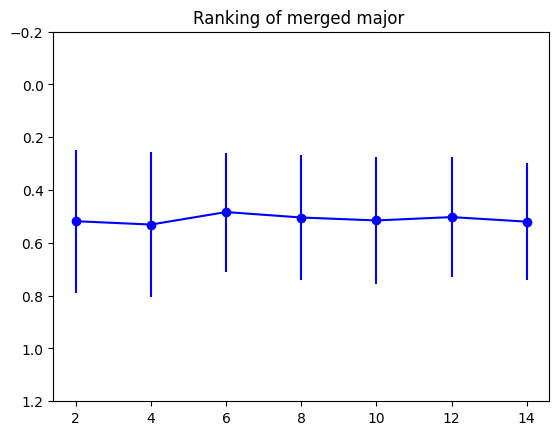

In [9]:
# Merge randomly selected majors
test_majors = adj_matrix.index

major_i_ranking_iter = pd.DataFrame()
major_i_sum_rca = pd.DataFrame()
major_i_mci =  pd.DataFrame()

for n in [2,4,6,8,10,12,14]:
    major_i_rankings_ = []
    major_i_rca_ = []
    major_i_mci_ = []
    for i in range(100):
        ranking_df = pd.DataFrame(index=adj_matrix.index)


        # Merge some of the education majors
        adj_matrix_simulation = adj_matrix.copy()
        ed_majors_to_merge = np.random.choice(test_majors, size=n, replace=False)
        adj_matrix_simulation.loc['merged_major'] = adj_matrix_simulation.loc[ed_majors_to_merge].sum()
        adj_matrix_simulation = adj_matrix_simulation.drop(ed_majors_to_merge)

        binary_matrix = binarize_by_rca(adj_matrix_simulation)
        mci_b_H = compute_mci_hajime(binary_matrix, iter=iterations)
        ranking = mci_b_H.iloc[:,-1].rank(ascending=True)
        # Adjust the direction
        major_ref_top = ranking.index[ranking.index.astype(str).str.startswith('21')][0]
        major_ref_bottom = ranking.index[ranking.index.astype(str).str.startswith('60')][0]
        if ranking[major_ref_top]>ranking[major_ref_bottom]:
            mci_b_H = -mci_b_H
            ranking = mci_b_H.iloc[:,-1].rank(ascending=True)


        major_i_rankings_.append(ranking['merged_major'])
        major_i_rca_.append(binary_matrix.loc['merged_major'].sum())
        major_i_mci_.append(mci_b_H.iloc[:,-1].loc['merged_major'])
    major_i_ranking_iter[n] = pd.Series(major_i_rankings_).describe()
    major_i_sum_rca[n] = pd.Series(major_i_rca_).describe()
    major_i_mci[n] = pd.Series(major_i_mci_).describe()


n_effective_majors = adj_matrix.shape[0]-np.array([2,4,6,8,10,12,14])+1

# Plot engineer_ranking_iter across n
fig, ax = plt.subplots()
ax.plot(major_i_ranking_iter.loc['mean']/n_effective_majors, label='mean',color='blue')
## Show std as error bar
ax.errorbar(major_i_ranking_iter.columns, major_i_ranking_iter.loc['mean']/n_effective_majors, yerr=major_i_ranking_iter.loc['std']/n_effective_majors, fmt='o', label='std',color='blue')
#dashed vertical line for the actual number 
ax.set_title(f'Ranking of merged major ')
# Flip y-axis
ax.invert_yaxis()
# Fix y-axis in 0-1
ax.set_ylim(1.2,-.2)


In [10]:
soc_level = 2
major_var = 'degfield'
major_name = df_degfield if major_var == 'degfield' else df_degfieldd
major_name.index.name = 'major'
if binarize_method == 'rca':
    binarize_threshold = 1.

# Read data
adj_matrix = pd.read_csv(f'../data/processed_data/acs/adj_{major_var}_soc{soc_level}.csv',index_col=0)
# Print df_degfieldd without truncation
pd.set_option('display.max_rows', None)

# df_degfield['degfield_s']

(1.2, -0.2)

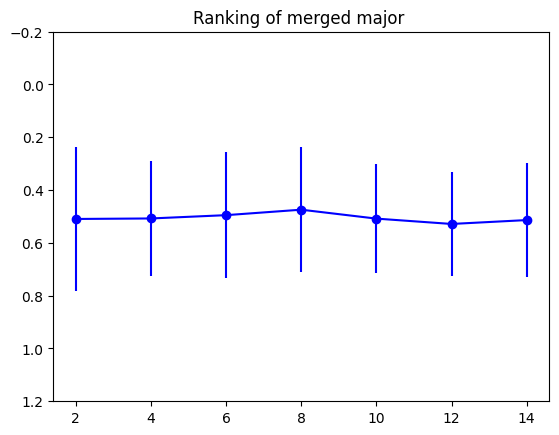

In [12]:
# Merge randomly selected majors

test_majors = adj_matrix.index

major_i_ranking_iter = pd.DataFrame()
major_i_sum_rca = pd.DataFrame()
major_i_mci =  pd.DataFrame()

for n in [2,4,6,8,10,12,14]:
    major_i_rankings_ = []
    major_i_rca_ = []
    major_i_mci_ = []
    for i in range(100):
        ranking_df = pd.DataFrame(index=adj_matrix.index)


        # Merge some of the education majors
        adj_matrix_simulation = adj_matrix.copy()
        ed_majors_to_merge = np.random.choice(test_majors, size=n, replace=False)
        adj_matrix_simulation.loc['merged_major'] = adj_matrix_simulation.loc[ed_majors_to_merge].sum()
        adj_matrix_simulation = adj_matrix_simulation.drop(ed_majors_to_merge)

        binary_matrix = binarize_by_rca(adj_matrix_simulation)
        mci_b_H = compute_mci_hajime(binary_matrix, iter=iterations)
        ranking = mci_b_H.iloc[:,-1].rank(ascending=True)
        # Adjust the direction
        try:
            major_ref_top = ranking.index[ranking.index.isin([21,24,14,37,25,50,36])][0]
        except:
            major_ref_top = 'merged_major'
        try:
            major_ref_bottom = ranking.index[ranking.index.isin([60,64,35,26,29,48,53])][0]
        except:
            major_ref_top = 'merged_major'
        if ranking[major_ref_top]>ranking[major_ref_bottom]:
            mci_b_H = -mci_b_H
            ranking = mci_b_H.iloc[:,-1].rank(ascending=True)


        major_i_rankings_.append(ranking['merged_major'])
        major_i_rca_.append(binary_matrix.loc['merged_major'].sum())
        major_i_mci_.append(mci_b_H.iloc[:,-1].loc['merged_major'])
    major_i_ranking_iter[n] = pd.Series(major_i_rankings_).describe()
    major_i_sum_rca[n] = pd.Series(major_i_rca_).describe()
    major_i_mci[n] = pd.Series(major_i_mci_).describe()


n_effective_majors = adj_matrix.shape[0]-np.array([2,4,6,8,10,12,14])+1

# Plot engineer_ranking_iter across n
fig, ax = plt.subplots()
ax.plot(major_i_ranking_iter.loc['mean']/n_effective_majors, label='mean',color='blue')
## Show std as error bar
ax.errorbar(major_i_ranking_iter.columns, major_i_ranking_iter.loc['mean']/n_effective_majors, yerr=major_i_ranking_iter.loc['std']/n_effective_majors, fmt='o', label='std',color='blue')
#dashed vertical line for the actual number 
ax.set_title(f'Ranking of merged major ')
# Flip y-axis
ax.invert_yaxis()
# Fix y-axis in 0-1
ax.set_ylim(1.2,-.2)


In [13]:
soc_level = 2
major_var = 'degfield'
major_name = df_degfield if major_var == 'degfield' else df_degfieldd
major_name.index.name = 'major'
if binarize_method == 'rca':
    binarize_threshold = 1.

# Read data
adj_matrix = pd.read_csv(f'../data/processed_data/acs/adj_{major_var}_soc{soc_level}.csv',index_col=0)
adj_matrix_degfieldd = pd.read_csv(f'../data/processed_data/acs/adj_degfieldd_soc{soc_level}.csv',index_col=0)


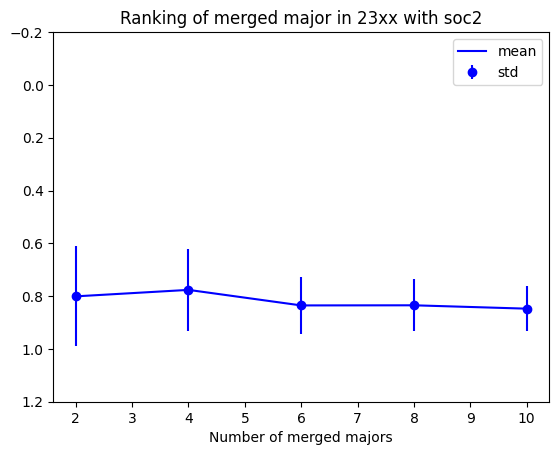

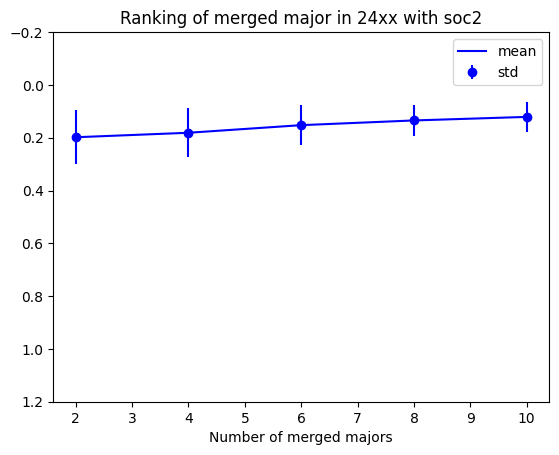

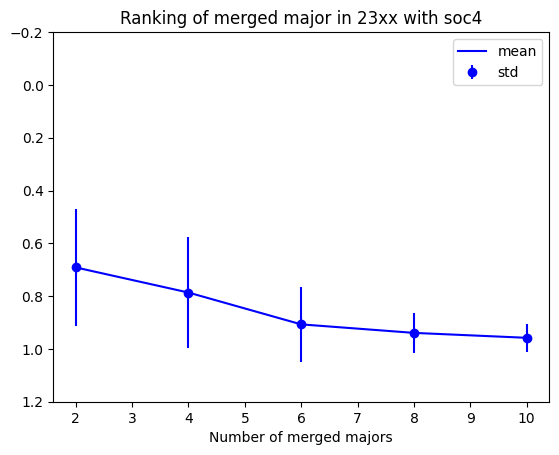

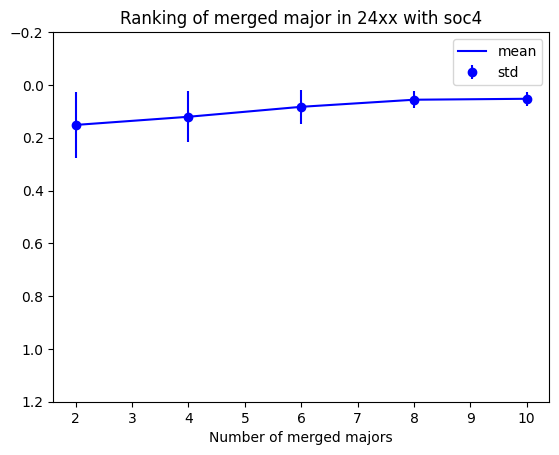

In [14]:
for soc_level in [2,4]:
    major_var = 'degfield'
    major_name = df_degfield if major_var == 'degfield' else df_degfieldd
    major_name.index.name = 'major'
    if binarize_method == 'rca':
        binarize_threshold = 1.

    # Read data
    adj_matrix = pd.read_csv(f'../data/processed_data/acs/adj_{major_var}_soc{soc_level}.csv',index_col=0)
    adj_matrix_degfieldd = pd.read_csv(f'../data/processed_data/acs/adj_degfieldd_soc{soc_level}.csv',index_col=0)

    for m in ['23','24']:

        test_majors = adj_matrix_degfieldd.index[adj_matrix_degfieldd.index.astype(str).str.startswith(m)]

        adj_matrix_ed_detailed = adj_matrix.copy()
        ## add test_majors as new rows
        for major in test_majors:
            adj_matrix_ed_detailed.loc[major] = adj_matrix_degfieldd.loc[major]

        # Remove 23
        adj_matrix_ed_detailed = adj_matrix_ed_detailed.drop([int(m)])

        major_i_ranking_iter = pd.DataFrame()
        major_i_sum_rca = pd.DataFrame()
        major_i_mci =  pd.DataFrame()
        major_i_change = pd.DataFrame()
        for n in [2,4,6,8,10]:
            major_i_rankings_ = []
            major_i_rca_ = []
            major_i_mci_ = []
            major_i_change_ = []
            for i in range(100):
                # Merge some of the education majors
                adj_matrix_simulation = adj_matrix_ed_detailed.copy()
                ed_majors_to_merge = np.random.choice(test_majors, size=n, replace=False)
                mean_ranking_merged_major = ranking_original[ed_majors_to_merge].mean()
                median_ranking_merged_major = ranking_original[ed_majors_to_merge].median()


                adj_matrix_simulation.loc['merged_major'] = adj_matrix_simulation.loc[ed_majors_to_merge].sum()
                adj_matrix_simulation = adj_matrix_simulation.drop(ed_majors_to_merge)

                binary_matrix = binarize_by_rca(adj_matrix_simulation)
                mci_b_H = compute_mci_hajime(binary_matrix, iter=iterations)
                ranking = mci_b_H.iloc[:,-1].rank(ascending=True)
                # Adjust the direction
                major_ref_top = major_ref_top_degfieldd if major_var == 'degfieldd' else major_ref_top_degfield
                major_ref_bottom = major_ref_bottom_degfieldd if major_var == 'degfieldd' else major_ref_bottom_degfield
                if ranking[major_ref_top]>ranking[major_ref_bottom]:
                    mci_b_H = -mci_b_H
                    ranking = mci_b_H.iloc[:,-1].rank(ascending=True)

                ranking_change_from_median = ranking['merged_major'] - median_ranking_merged_major

                major_i_rankings_.append(ranking['merged_major'])
                major_i_rca_.append(binary_matrix.loc['merged_major'].sum())
                major_i_mci_.append(mci_b_H.iloc[:,-1].loc['merged_major'])
                major_i_change_.append(ranking_change_from_median)
            major_i_ranking_iter[n] = pd.Series(major_i_rankings_).describe()
            major_i_ranking_iter.loc['mean_of_merged',n] = mean_ranking_merged_major

            major_i_sum_rca[n] = pd.Series(major_i_rca_).describe()
            major_i_mci[n] = pd.Series(major_i_mci_).describe()

            major_i_change[n] = pd.Series(major_i_change_).describe()

        n_effective_majors = adj_matrix_ed_detailed.shape[0]-np.array([2,4,6,8,10])+1


        # Plot engineer_ranking_iter across n
        fig, ax = plt.subplots()
        ax.plot(major_i_ranking_iter.loc['mean']/n_effective_majors, label='mean',color='blue')
        ## Show std as error bar
        ax.errorbar(major_i_ranking_iter.columns, major_i_ranking_iter.loc['mean']/n_effective_majors, yerr=major_i_ranking_iter.loc['std']/n_effective_majors, fmt='o', label='std',color='blue')
        #dashed vertical line for the actual number 
        ax.set_title(f'Ranking of merged major in {m}xx with soc{soc_level}')
        # Flip y-axis
        ax.invert_yaxis()
        # Fix y-axis in 0-1
        ax.set_ylim(1.2,-.2)

        ax.set_xlabel('Number of merged majors')

        # Save fig
        plt.legend()
        plt.savefig(f'../results_JHR_revision2/merged_{m}xx_ranking_in_degfield_soc{soc_level}.pdf')



        '''
        # Plot change of the ranking
        fig, ax = plt.subplots()
        ax.plot(major_i_change.loc['mean'], label='mean',color='blue')
        ## Show std as error bar
        ax.errorbar(major_i_change.columns, major_i_change.loc['mean'], yerr=major_i_change.loc['std'], fmt='o', label='std',color='blue')
        #dashed vertical line for the actual number 
        ax.set_title(f'Ranking change of merged major in {m}xx from median with soc{soc_level}')
        # Flip y-axis
        ax.invert_yaxis()

        ax.set_xlabel('Number of merged majors')

        # Save fig
        plt.legend()
        plt.savefig(f'../results_JHR_revision2/merged_{m}xx_ranking_change_in_degfield_soc{soc_level}.pdf')
        '''


In [15]:
soc_level=4
major_var = 'degfield'
major_name = df_degfield if major_var == 'degfield' else df_degfieldd
major_name.index.name = 'major'
if binarize_method == 'rca':
    binarize_threshold = 1.

# Read data
adj_matrix = pd.read_csv(f'../data/processed_data/acs/adj_{major_var}_soc{soc_level}.csv',index_col=0)
o ='25'
test_occupations = adj_matrix.columns[adj_matrix.columns.astype(str).str.startswith(o)]


In [23]:
adj_matrix_soc4.columns[adj_matrix_soc4.columns.astype(str).str.startswith('17')]

Index(['1710', '1720', '1730'], dtype='object')

o,m: 17 23


o,m: 17 24
o,m: 25 23
o,m: 25 24


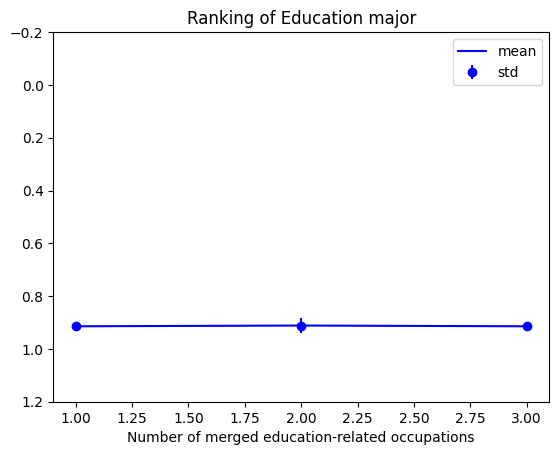

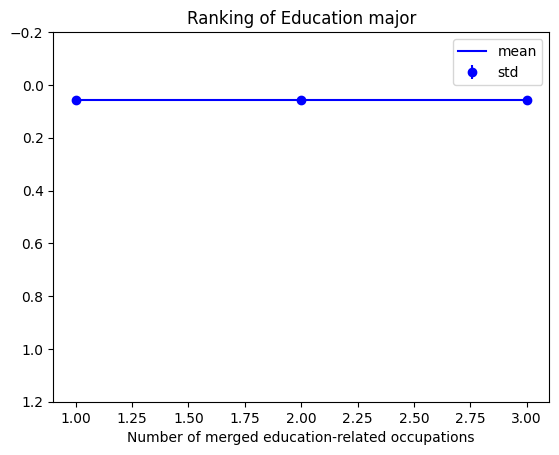

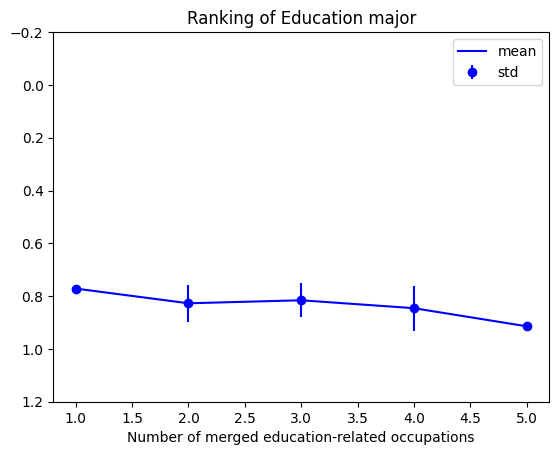

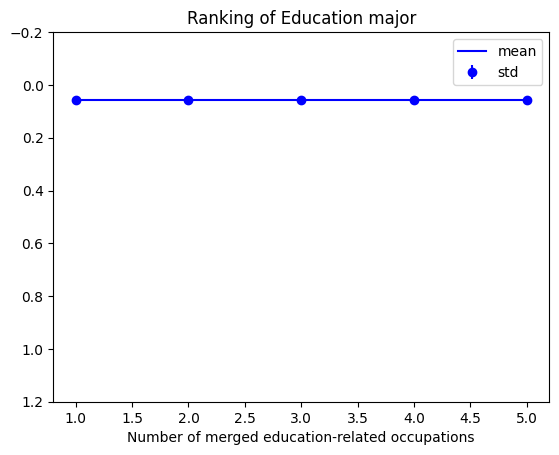

In [27]:
major_var = 'degfield'
major_name = df_degfield if major_var == 'degfield' else df_degfieldd
major_name.index.name = 'major'
if binarize_method == 'rca':
    binarize_threshold = 1.

# Read data
adj_matrix = pd.read_csv(f'../data/processed_data/acs/adj_{major_var}_soc2.csv',index_col=0)
adj_matrix_soc4 = pd.read_csv(f'../data/processed_data/acs/adj_{major_var}_soc4.csv',index_col=0)


for o in ['17','25']:
    for m in ['23','24']:
        print('o,m:',o,m)
        test_occupations = adj_matrix_soc4.columns[adj_matrix_soc4.columns.astype(str).str.startswith(o)]
        major_i_ranking_iter = pd.DataFrame()
        max_n = 5 if o=='25' else 3
        for n in range(1,max_n+1):
            rankings_ = []
            major_i_rankings_ = []
            for i in range(20):
                adj_matrix_ed_detailed = adj_matrix.copy()
                ## add test_majors as new rows
                for occ in test_occupations:
                    adj_matrix_ed_detailed.loc[:,occ] = adj_matrix_soc4.loc[:,occ]
                # Remove 23
                adj_matrix_ed_detailed = adj_matrix_ed_detailed.drop(columns=[o])

                # Merge some of the education majors
                adj_matrix_simulation = adj_matrix_ed_detailed.copy()
                ed_occs_to_merge = np.random.choice(test_occupations, size=n, replace=False)


                adj_matrix_simulation.loc[:,'merged_occ'] = adj_matrix_ed_detailed.loc[:,ed_occs_to_merge].sum(axis=1)
                adj_matrix_simulation = adj_matrix_simulation.drop(columns=ed_occs_to_merge)

                binary_matrix = binarize_by_rca(adj_matrix_simulation)
                mci_b_H = compute_mci_hajime(binary_matrix, iter=iterations)
                ranking = mci_b_H.iloc[:,-1].rank(ascending=True)
                # Adjust the direction
                major_ref_top = major_ref_top_degfieldd if major_var == 'degfieldd' else major_ref_top_degfield
                major_ref_bottom = major_ref_bottom_degfieldd if major_var == 'degfieldd' else major_ref_bottom_degfield
                if ranking[major_ref_top]>ranking[major_ref_bottom]:
                    mci_b_H = -mci_b_H
                    ranking = mci_b_H.iloc[:,-1].rank(ascending=True)

                rankings_.append(ranking)

                major_i_rankings_.append(ranking[int(m)])
            major_i_ranking_iter[n] = pd.Series(major_i_rankings_).describe()
            pd.concat(rankings_,axis=1)

        n_effective_majors = adj_matrix.shape[0]
        # Plot engineer_ranking_iter across n
        fig, ax = plt.subplots()
        ax.plot(major_i_ranking_iter.loc['mean']/n_effective_majors, label='mean',color='blue')
        ## Show std as error bar
        ax.errorbar(major_i_ranking_iter.columns, major_i_ranking_iter.loc['mean']/n_effective_majors, yerr=major_i_ranking_iter.loc['std']/n_effective_majors, fmt='o', label='std',color='blue')
        #dashed vertical line for the actual number 
        ax.set_title(f'Ranking of Education major')
        # Flip y-axis
        ax.invert_yaxis()
        ax.set_ylim(1.2,-.2)


        ax.set_xlabel('Number of merged education-related occupations')


        # Save fig
        plt.legend()
        plt.savefig(f'../results_JHR_revision2/merge_occ_{o}xx_ranking_{m}_soc2.pdf')


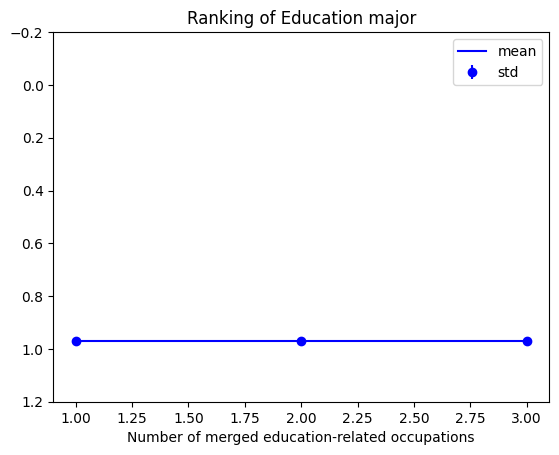

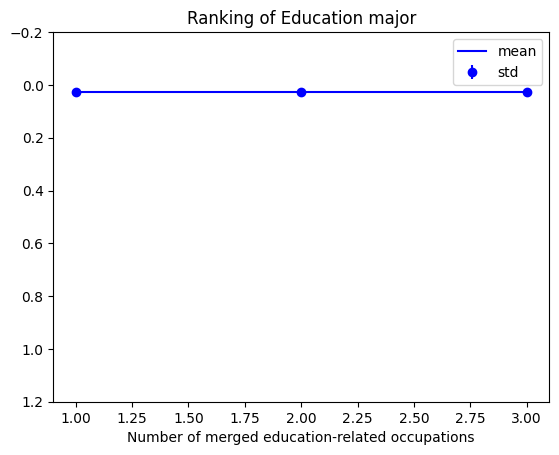

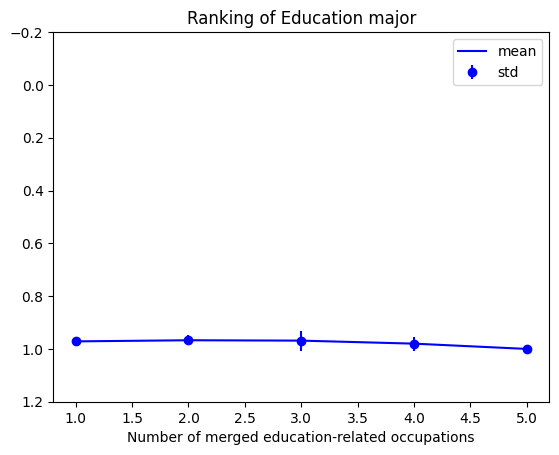

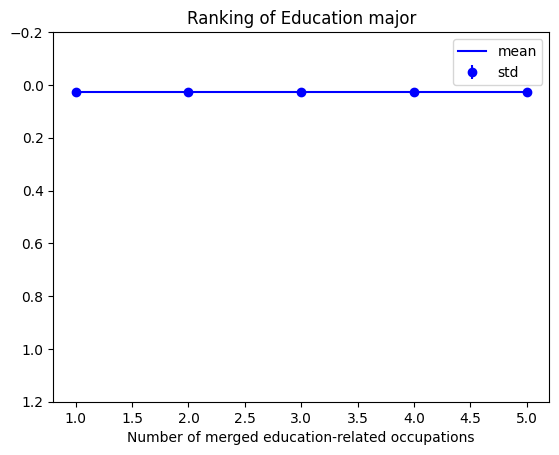

In [28]:
major_var = 'degfield'
major_name = df_degfield if major_var == 'degfield' else df_degfieldd
major_name.index.name = 'major'
if binarize_method == 'rca':
    binarize_threshold = 1.

# Read data
adj_matrix = pd.read_csv(f'../data/processed_data/acs/adj_{major_var}_soc2.csv',index_col=0)
adj_matrix_soc4 = pd.read_csv(f'../data/processed_data/acs/adj_{major_var}_soc4.csv',index_col=0)


for o in ['17','25']:
    for m in ['23','24']:
        test_occupations = adj_matrix_soc4.columns[adj_matrix_soc4.columns.astype(str).str.startswith(o)]

        major_i_ranking_iter = pd.DataFrame()
        max_n = 5 if o=='25' else 3
        for n in range(1,max_n+1):
            rankings_ = []
            major_i_rankings_ = []
            for i in range(20):
                adj_matrix_ed_detailed = adj_matrix_soc4.copy()

                # Merge some of the education majors
                adj_matrix_simulation = adj_matrix_ed_detailed.copy()
                ed_occs_to_merge = np.random.choice(test_occupations, size=n, replace=False)


                adj_matrix_simulation.loc[:,'merged_occ'] = adj_matrix_ed_detailed.loc[:,ed_occs_to_merge].sum(axis=1)
                adj_matrix_simulation = adj_matrix_simulation.drop(columns=ed_occs_to_merge)

                binary_matrix = binarize_by_rca(adj_matrix_simulation)
                mci_b_H = compute_mci_hajime(binary_matrix, iter=iterations)
                ranking = mci_b_H.iloc[:,-1].rank(ascending=True)
                # Adjust the direction
                major_ref_top = major_ref_top_degfieldd if major_var == 'degfieldd' else major_ref_top_degfield
                major_ref_bottom = major_ref_bottom_degfieldd if major_var == 'degfieldd' else major_ref_bottom_degfield
                if ranking[major_ref_top]>ranking[major_ref_bottom]:
                    mci_b_H = -mci_b_H
                    ranking = mci_b_H.iloc[:,-1].rank(ascending=True)

                rankings_.append(ranking)

                major_i_rankings_.append(ranking[int(m)])
            major_i_ranking_iter[n] = pd.Series(major_i_rankings_).describe()
            pd.concat(rankings_,axis=1)

        n_effective_majors = adj_matrix.shape[0]
        # Plot engineer_ranking_iter across n
        fig, ax = plt.subplots()
        ax.plot(major_i_ranking_iter.loc['mean']/n_effective_majors, label='mean',color='blue')
        ## Show std as error bar
        ax.errorbar(major_i_ranking_iter.columns, major_i_ranking_iter.loc['mean']/n_effective_majors, yerr=major_i_ranking_iter.loc['std']/n_effective_majors, fmt='o', label='std',color='blue')
        #dashed vertical line for the actual number 
        ax.set_title(f'Ranking of Education major')
        # Flip y-axis
        ax.invert_yaxis()
        ax.set_ylim(1.2,-.2)

        ax.set_xlabel('Number of merged education-related occupations')


        # Save fig
        plt.legend()
        plt.savefig(f'../results_JHR_revision2/merge_occ_{o}xx_ranking_{m}_soc4.pdf')


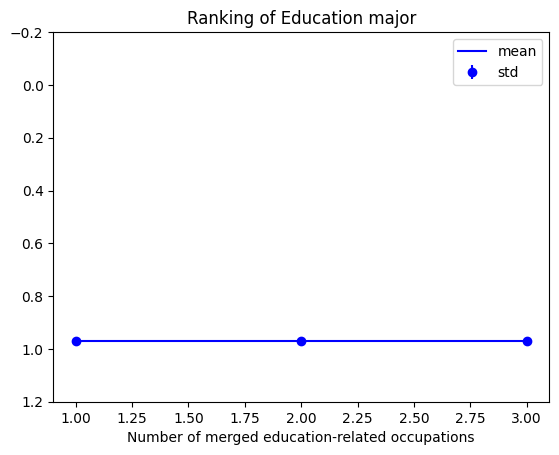

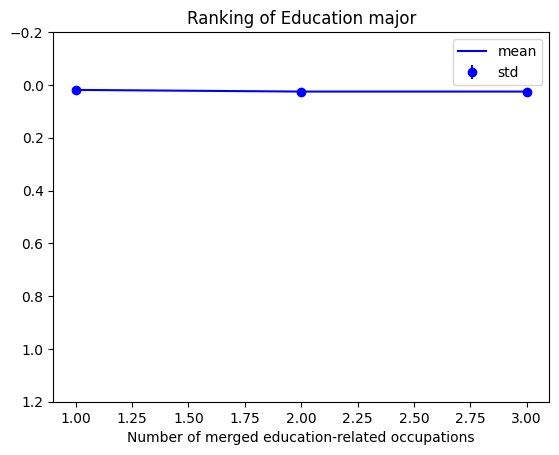

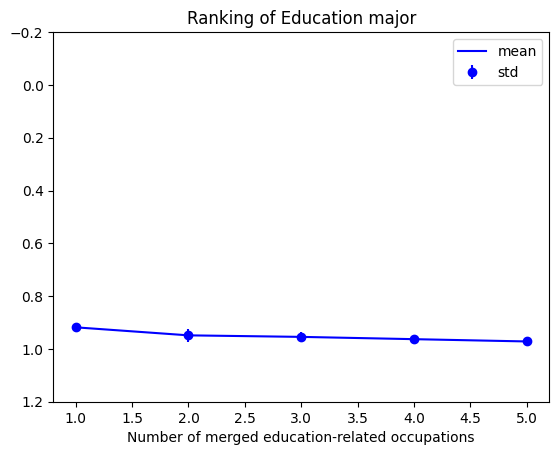

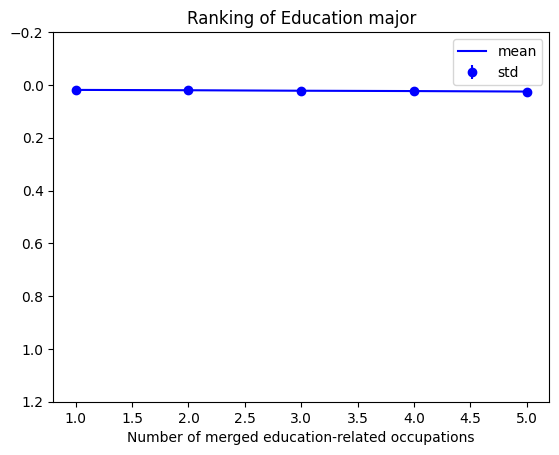

In [31]:
major_var = 'degfieldd'
major_name = df_degfield if major_var == 'degfield' else df_degfieldd
major_name.index.name = 'major'
if binarize_method == 'rca':
    binarize_threshold = 1.

# Read data
adj_matrix = pd.read_csv(f'../data/processed_data/acs/adj_{major_var}_soc2.csv',index_col=0)
adj_matrix_soc4 = pd.read_csv(f'../data/processed_data/acs/adj_{major_var}_soc4.csv',index_col=0)



for o in ['17','25']:
    for m in ['2304','2407']:
        test_occupations = adj_matrix_soc4.columns[adj_matrix_soc4.columns.astype(str).str.startswith(o)]

        major_i_ranking_iter = pd.DataFrame()
        max_n = 5 if o=='25' else 3
        for n in range(1,max_n+1):
            rankings_ = []
            major_i_rankings_ = []
            for i in range(20):
                adj_matrix_ed_detailed = adj_matrix.copy()
                ## add test_majors as new rows
                for occ in test_occupations:
                    adj_matrix_ed_detailed.loc[:,occ] = adj_matrix_soc4.loc[:,occ]
                # Remove 23
                adj_matrix_ed_detailed = adj_matrix_ed_detailed.drop(columns=o)

                # Merge some of the education majors
                adj_matrix_simulation = adj_matrix_ed_detailed.copy()
                ed_occs_to_merge = np.random.choice(test_occupations, size=n, replace=False)


                adj_matrix_simulation.loc[:,'merged_occ'] = adj_matrix_ed_detailed.loc[:,ed_occs_to_merge].sum(axis=1)
                adj_matrix_simulation = adj_matrix_simulation.drop(columns=ed_occs_to_merge)

                binary_matrix = binarize_by_rca(adj_matrix_simulation)
                mci_b_H = compute_mci_hajime(binary_matrix, iter=iterations)
                ranking = mci_b_H.iloc[:,-1].rank(ascending=True)
                # Adjust the direction
                major_ref_top = major_ref_top_degfieldd if major_var == 'degfieldd' else major_ref_top_degfield
                major_ref_bottom = major_ref_bottom_degfieldd if major_var == 'degfieldd' else major_ref_bottom_degfield
                if ranking[major_ref_top]>ranking[major_ref_bottom]:
                    mci_b_H = -mci_b_H
                    ranking = mci_b_H.iloc[:,-1].rank(ascending=True)

                rankings_.append(ranking)

                major_i_rankings_.append(ranking[int(m)])
            major_i_ranking_iter[n] = pd.Series(major_i_rankings_).describe()
            pd.concat(rankings_,axis=1)
        n_effective_majors = adj_matrix.shape[0]

        # Plot engineer_ranking_iter across n
        fig, ax = plt.subplots()
        ax.plot(major_i_ranking_iter.loc['mean']/n_effective_majors, label='mean',color='blue')
        ## Show std as error bar
        ax.errorbar(major_i_ranking_iter.columns, major_i_ranking_iter.loc['mean']/n_effective_majors, yerr=major_i_ranking_iter.loc['std']/n_effective_majors, fmt='o', label='std',color='blue')
        #dashed vertical line for the actual number 
        ax.set_title(f'Ranking of Education major')
        # Flip y-axis
        ax.invert_yaxis()
        ax.set_ylim(1.2,-.2)

        ax.set_xlabel('Number of merged education-related occupations')


        # Save fig
        plt.legend()
        plt.savefig(f'../results_JHR_revision2/merge_occ_{o}xx_ranking_{m}_soc2.pdf')


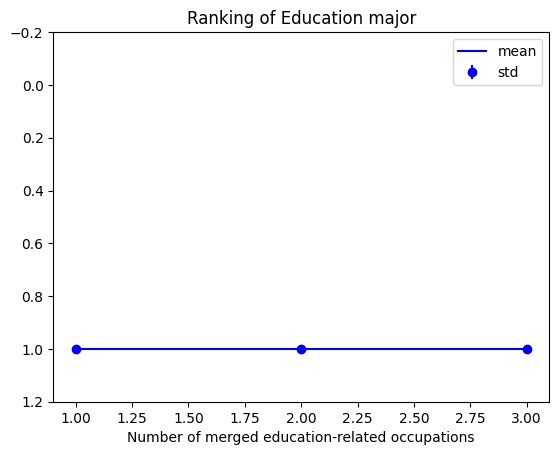

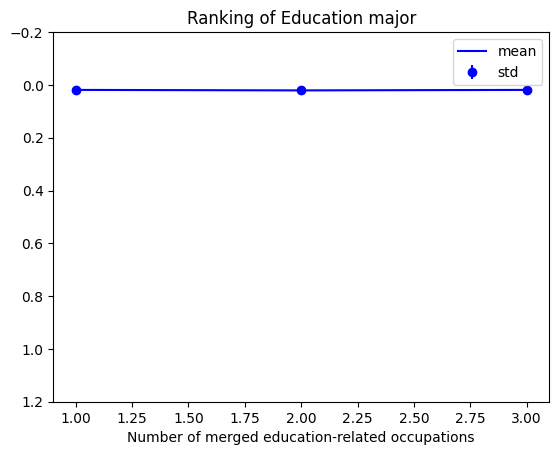

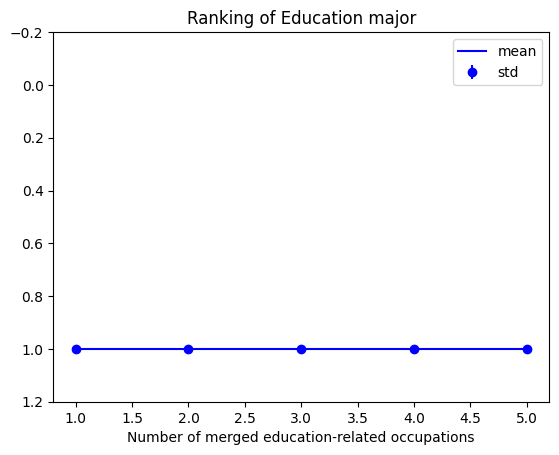

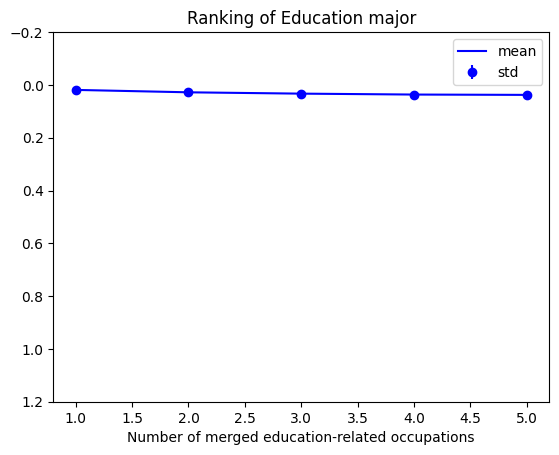

In [32]:
major_var = 'degfieldd'
major_name = df_degfield if major_var == 'degfield' else df_degfieldd
major_name.index.name = 'major'
if binarize_method == 'rca':
    binarize_threshold = 1.

# Read data
adj_matrix = pd.read_csv(f'../data/processed_data/acs/adj_{major_var}_soc2.csv',index_col=0)
adj_matrix_soc4 = pd.read_csv(f'../data/processed_data/acs/adj_{major_var}_soc4.csv',index_col=0)


for o in ['17','25']:
    for m in ['2304','2407']:
        test_occupations = adj_matrix_soc4.columns[adj_matrix_soc4.columns.astype(str).str.startswith(o)]



        major_i_ranking_iter = pd.DataFrame()
        max_n = 5 if o=='25' else 3
        for n in range(1,max_n+1):
            rankings_ = []
            major_i_rankings_ = []
            for i in range(20):
                adj_matrix_ed_detailed = adj_matrix_soc4.copy()

                # Merge some of the education occupations
                adj_matrix_simulation = adj_matrix_ed_detailed.copy()
                ed_occs_to_merge = np.random.choice(test_occupations, size=n, replace=False)


                adj_matrix_simulation.loc[:,'merged_occ'] = adj_matrix_ed_detailed.loc[:,ed_occs_to_merge].sum(axis=1)
                adj_matrix_simulation = adj_matrix_simulation.drop(columns=ed_occs_to_merge)

                binary_matrix = binarize_by_rca(adj_matrix_simulation)
                mci_b_H = compute_mci_hajime(binary_matrix, iter=iterations)
                ranking = mci_b_H.iloc[:,-1].rank(ascending=True)
                # Adjust the direction
                major_ref_top = major_ref_top_degfieldd if major_var == 'degfieldd' else major_ref_top_degfield
                major_ref_bottom = major_ref_bottom_degfieldd if major_var == 'degfieldd' else major_ref_bottom_degfield
                if ranking[major_ref_top]>ranking[major_ref_bottom]:
                    mci_b_H = -mci_b_H
                    ranking = mci_b_H.iloc[:,-1].rank(ascending=True)

                rankings_.append(ranking)

                major_i_rankings_.append(ranking[int(m)])
            major_i_ranking_iter[n] = pd.Series(major_i_rankings_).describe()
            pd.concat(rankings_,axis=1)

        n_effective_majors = adj_matrix.shape[0]

        # Plot engineer_ranking_iter across n
        fig, ax = plt.subplots()
        ax.plot(major_i_ranking_iter.loc['mean']/n_effective_majors, label='mean',color='blue')
        ## Show std as error bar
        ax.errorbar(major_i_ranking_iter.columns, major_i_ranking_iter.loc['mean']/n_effective_majors, yerr=major_i_ranking_iter.loc['std']/n_effective_majors, fmt='o', label='std',color='blue')
        #dashed vertical line for the actual number 
        ax.set_title(f'Ranking of Education major')
        # Flip y-axis
        ax.invert_yaxis()
        ax.set_ylim(1.2,-.2)

        ax.set_xlabel('Number of merged education-related occupations')


        # Save fig
        plt.legend()
        plt.savefig(f'../results_JHR_revision2/merge_occ_{o}xx_ranking_{m}_soc4.pdf')
